## Resaurant recommendation on <img src='https://i.ibb.co/WPRs7cn/Yelp-Logo-svg.png' width='50'/> data, based on collaborative filtering


Samyak R Jain, Himanshu Kandapal, Aayush Birla, Sanivada Sai Chaitanya

Recommender systems are an integral part of many online systems. From e-commerce to online streaming platforms.
Recommender systems employ the past purchase patters on it's user to predict which other products they may in interested in and likey to purchase. Recommending the right products gives a significat advantage to the business. A mojor portion of the revenue is generated through recommendations.


The Collaborative Filtering algorithm is very popular in online streaming platforms and e-commerse sites where the customer interacts with each product (which can be a movie/ song or consumer products) by either liking/ disliking or giving a rating of sorts.
One of the requirements to be able to apply collaborative filtering is that sufficient number of products need ratings associated with not them. User interaction is required.

Yelp.com, is a crowd-sourced local business review and social networking site. The site has pages devoted to individual locations, such as restaurants or schools, where Yelp users can submit a review of their products or services using a one to five star rating scale. Businesses can also update contact information, hours, and other basic listing information or add special deals. In addition to writing reviews, users can react to reviews, plan events, or discuss their personal lives.

# Importing libraries

In [ ]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading and cleaning the data

In [ ]:
# import shutil
# shutil.unpack_archive('/content/gdrive/MyDrive/ds2/yelp_dataset.tgz', '/content/gdrive/MyDrive/ds2')

In [ ]:
business_df=pd.read_json('/content/gdrive/MyDrive/ds2/yelp_academic_dataset_business.json', lines =True)

In [ ]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [ ]:
business_df.shape

(160585, 14)

In [ ]:
business_df=business_df[(business_df.categories.notna()) & (business_df.is_open==1)]

In [ ]:
business_df_clean=business_df.loc[business_df.categories.str.contains('Restaurant', case=False), :]

In [ ]:
business_df_clean.shape

(32049, 14)

In [ ]:
restaurants_list=business_df_clean.business_id.tolist()

In [ ]:
dtype_dict={'review_id':str, 'user_id':str,'business_id':str,
            'stars':int, 'date': str, 'text':str, 'useful': int,'funny':int,'cool':int}

In [ ]:
review_df=pd.read_json('/content/gdrive/MyDrive/ds2/yelp_academic_dataset_review.json',dtype=dtype_dict, chunksize=1000000, lines=True)

In [ ]:
review_list=[]

for review_chunk in review_df:
  mask=(review_chunk.business_id.isin(restaurants_list))
  review_chunk_trimmed=(review_chunk[mask]).drop(columns=['text'])
  review_list.append(review_chunk_trimmed) 

In [ ]:
review_final_df=pd.concat(review_list, axis=0)
review_final_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,2010-01-08 02:29:15
5,J4a2TuhDasjn2k3wWtHZnQ,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,1,2,0,0,2018-01-21 04:41:03
7,9vqwvFCBG3FBiHGmOHMmiA,XGkAG92TQ3MQUKGX9sLUhw,DbXHNl890xSXNiyRczLWAg,5,0,0,0,2017-12-02 18:16:13
12,Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,TA1KUSCu8GkWP9w0rmElxw,4,0,0,0,2011-10-27 14:32:57
14,j_eh6Iw7qseluR-7KfZOMg,xpxWG7jQXZE6BcSeuIq4PQ,mw_qxZJraNu7Q6u0GkcMew,5,0,0,0,2016-08-12 21:59:03


In [ ]:
review_final_df.reset_index(drop=True,inplace=True)

In [ ]:
review_final_df.to_csv('/content/gdrive/MyDrive/ds2/review_trimmed.csv',index=False)

In [ ]:
review_final_df=pd.read_csv('/content/gdrive/MyDrive/ds2/review_trimmed.csv')

In [ ]:
user_list=review_final_df.user_id.unique().tolist()

In [ ]:
dtypes_dict={'user_id':str,'name':str, 'review_count':int, 'yelping_since':str,
             'friends':object, 'useful':int, 'funny':int, 'cool':int, 'fans':int,
             'elite':object, 'average_stars':float, "compliment_hot":int, "compliment_more":int,
             "compliment_profile":int, "compliment_cute":int, "compliment_list":int, "compliment_note":int
             , "compliment_plain":int, "compliment_cool":int, "compliment_funny":int, "compliment_writer":int
             , "compliment_photos":int}
user_df=pd.read_json('/content/gdrive/MyDrive/ds2/yelp_academic_dataset_user.json', lines=True, chunksize=100000, dtype=dtypes_dict)

In [ ]:
user_final=pd.DataFrame()

for user_chunk in user_df:
  mask=user_chunk.user_id.isin(user_list)
  user_final=user_final.append(user_chunk[mask])

user_final.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294
2,D6ErcUnFALnCQN4b1W_TlA,Jason,119,2007-02-07 15:47:53,188,128,130,"2010,2011","GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",16,3.76,22,1,3,0,0,5,20,31,31,3,1
3,JnPIjvC0cmooNDfsa9BmXg,Kat,987,2009-02-09 16:14:29,7234,4722,4035,"2009,2010,2011,2012,2013,2014","HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",420,3.77,1180,129,93,219,90,1120,4510,1566,1566,391,326
4,37Hc8hr3cw0iHLoPzLK6Ow,Christine,495,2008-03-03 04:57:05,1577,727,1124,"2009,2010,2011","-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",47,3.72,248,19,32,16,15,77,131,310,310,98,44


In [ ]:
user_final.shape

(1364404, 22)

In [ ]:
user_final.to_csv('/content/gdrive/MyDrive/ds2/user_trimmed.csv', index=False)

In [ ]:
user_final=pd.read_csv('/content/gdrive/MyDrive/ds2/user_trimmed.csv')

In [ ]:
review_final_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,2010-01-08 02:29:15
1,J4a2TuhDasjn2k3wWtHZnQ,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,1,2,0,0,2018-01-21 04:41:03
2,9vqwvFCBG3FBiHGmOHMmiA,XGkAG92TQ3MQUKGX9sLUhw,DbXHNl890xSXNiyRczLWAg,5,0,0,0,2017-12-02 18:16:13
3,Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,TA1KUSCu8GkWP9w0rmElxw,4,0,0,0,2011-10-27 14:32:57
4,j_eh6Iw7qseluR-7KfZOMg,xpxWG7jQXZE6BcSeuIq4PQ,mw_qxZJraNu7Q6u0GkcMew,5,0,0,0,2016-08-12 21:59:03


In [ ]:
user_final.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294
2,D6ErcUnFALnCQN4b1W_TlA,Jason,119,2007-02-07 15:47:53,188,128,130,"2010,2011","GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",16,3.76,22,1,3,0,0,5,20,31,31,3,1
3,JnPIjvC0cmooNDfsa9BmXg,Kat,987,2009-02-09 16:14:29,7234,4722,4035,"2009,2010,2011,2012,2013,2014","HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",420,3.77,1180,129,93,219,90,1120,4510,1566,1566,391,326
4,37Hc8hr3cw0iHLoPzLK6Ow,Christine,495,2008-03-03 04:57:05,1577,727,1124,"2009,2010,2011","-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",47,3.72,248,19,32,16,15,77,131,310,310,98,44


In [ ]:
business_df_clean.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
7,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}"
12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [ ]:
users=review_final_df.user_id.unique()
restaurants=review_final_df.business_id.unique()

In [ ]:
userid2idx={u:i for i,u in enumerate(users)}
restaurantsid2idx={r:i for i,r in enumerate(restaurants)}

In [ ]:
review_final_df['user_id']=review_final_df['user_id'].apply(lambda x : userid2idx[x])
review_final_df['business_id']=review_final_df['business_id'].apply(lambda x: restaurantsid2idx[x])

business_df_clean['id']=business_df_clean['business_id'].apply(lambda x : restaurantsid2idx[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
review_final_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,T5fAqjjFooT4V0OeZyuk1w,0,0,2,1,1,1,2010-01-08 02:29:15
1,J4a2TuhDasjn2k3wWtHZnQ,1,1,1,2,0,0,2018-01-21 04:41:03
2,9vqwvFCBG3FBiHGmOHMmiA,2,2,5,0,0,0,2017-12-02 18:16:13
3,Gi5LSRmTXoL9Bp4jNGPjLw,3,3,4,0,0,0,2011-10-27 14:32:57
4,j_eh6Iw7qseluR-7KfZOMg,4,4,5,0,0,0,2016-08-12 21:59:03


In [ ]:
business_df_clean.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,id
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1461
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",340
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...",954
7,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}",3196
12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1444


In [ ]:
business_df_clean=business_df_clean.set_index('id')

In [ ]:
business_df_clean.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
id,,,,,,,,,,,,,,
1461,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
340,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
954,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
3196,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}"
1444,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [ ]:
review_final_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,T5fAqjjFooT4V0OeZyuk1w,0,0,2,1,1,1,2010-01-08 02:29:15
1,J4a2TuhDasjn2k3wWtHZnQ,1,1,1,2,0,0,2018-01-21 04:41:03
2,9vqwvFCBG3FBiHGmOHMmiA,2,2,5,0,0,0,2017-12-02 18:16:13
3,Gi5LSRmTXoL9Bp4jNGPjLw,3,3,4,0,0,0,2011-10-27 14:32:57
4,j_eh6Iw7qseluR-7KfZOMg,4,4,5,0,0,0,2016-08-12 21:59:03


In [ ]:
business_names=business_df_clean.name.to_dict()

In [ ]:
nusers=review_final_df.user_id.nunique()
nrestaurants=review_final_df.business_id.nunique()
nusers,nrestaurants

(1364404, 32049)

# Setting up the model.

In [ ]:
review_final_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,T5fAqjjFooT4V0OeZyuk1w,0,0,2,1,1,1,2010-01-08 02:29:15
1,J4a2TuhDasjn2k3wWtHZnQ,1,1,1,2,0,0,2018-01-21 04:41:03
2,9vqwvFCBG3FBiHGmOHMmiA,2,2,5,0,0,0,2017-12-02 18:16:13
3,Gi5LSRmTXoL9Bp4jNGPjLw,3,3,4,0,0,0,2011-10-27 14:32:57
4,j_eh6Iw7qseluR-7KfZOMg,4,4,5,0,0,0,2016-08-12 21:59:03


In [ ]:
business_df_clean.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
id,,,,,,,,,,,,,,
1461,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
340,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
954,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
3196,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}"
1444,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [ ]:
train_indices, val_indices=train_test_split(range(review_final_df.shape[0]), train_size=0.8)
train_df=review_final_df.iloc[train_indices]
val_df=review_final_df.iloc[val_indices]
train_df.shape, val_df.shape

((3444464, 8), (861116, 8))

In [ ]:
#size of the latent factor
L=200
#regularization
REG=10e-4

# Modeling

In [ ]:
#function for returning bias layer
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

#function for returning input layer , embedding layer
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [ ]:
#defining embeddings and biases

user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restaurant_input, rLmat = embedding_input('restaurant_input', nrestaurants, L, REG)

In [ ]:
#placeholders for user_id s and business_id s
user_input.shape, restaurant_input.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [ ]:
uLmat.shape, rLmat.shape

(TensorShape([None, 1, 200]), TensorShape([None, 1, 200]))

In [ ]:
user_bias=create_bias('user_bias', user_input, nusers, REG)
restaurant_bias=create_bias('restaurant_bias', restaurant_input, nrestaurants, REG)

user_bias.shape, restaurant_bias.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [ ]:
# embeddings are matrix multiplied together (dot producted together) to get the residual matrix
residual = Dot(axes=2, name="residual")([uLmat, rLmat])
residual.shape

TensorShape([None, 1, 1])

In [ ]:
#flattening the residual matrix
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [ ]:
#adding residual and biases to a linear regression
regression = Add(name="regression")([user_bias, restaurant_bias, residflat])
regression.shape

TensorShape([None, 1])

In [ ]:
#defining a sigmoid with a custom range to limit the linear regression predictions between 0 and 5.5
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [ ]:
cs=sigmoid_maker(0,5.5)

In [ ]:
output=Activation(cs, name='sigmoid_range')(regression)

In [ ]:
model=Model([user_input, restaurant_input], output)
model.compile(SGD(0.001) , loss='mse')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 restaurant_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 200)       272880800   ['user_input[0][0]']             
                                                                                                  
 restaurant_factor (Embedding)  (None, 1, 200)       6409800     ['restaurant_input[0][0]']       
                                                                                            

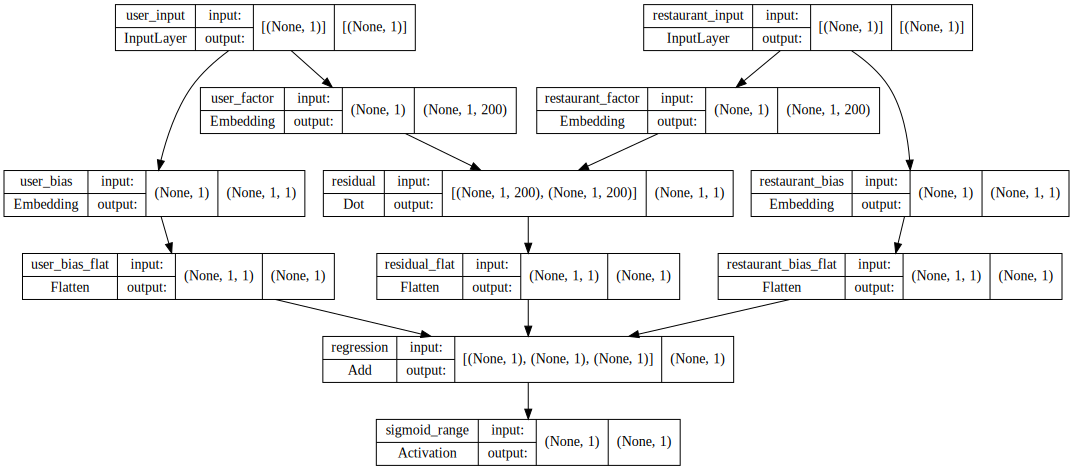

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

Training the model

In [ ]:
train_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
1332094,hD_oToHoqTTdbFLkz_Bweg,316171,9669,4,0,0,0,2011-07-02 05:01:38
1650561,LQOj2j0AkDjWFfH_qNAF5Q,747316,10420,5,0,0,0,2018-04-02 19:21:46
2604906,t9HoPr-UkL9_okXrowAz5g,100102,19793,5,0,0,0,2011-07-02 04:50:26
1198336,VT8a19SthpGorIRhWj27Cg,192088,6450,5,0,0,0,2019-05-19 02:18:39
906895,1uPhzqMSo4F9EgkVO2adlw,492826,6484,2,0,1,0,2016-02-14 03:36:37


In [ ]:
nusers, nrestaurants

(1364404, 32049)

In [ ]:
model.optimizer.lr=4
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=16384, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 272880800 elements. This may consume a large amount of memory.
  num_elements)


211/211 [==============================] - 486s 2s/step - loss: 69.3369 - val_loss: 10.0955


In [ ]:
model.optimizer.lr=1
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=16384, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

211/211 [==============================] - 472s 2s/step - loss: 7.5307 - val_loss: 5.5636


In [ ]:
model.optimizer.lr=0.2
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=16384, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

211/211 [==============================] - 483s 2s/step - loss: 5.5565 - val_loss: 5.5636


In [ ]:
model.optimizer.lr=0.05
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=16384, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

211/211 [==============================] - 495s 2s/step - loss: 5.5565 - val_loss: 5.5636


In [ ]:
model.optimizer.lr=1
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=8192, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

421/421 [==============================] - 938s 2s/step - loss: 3.7669 - val_loss: 2.7154


In [ ]:
model.optimizer.lr=0.5
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=8192, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

421/421 [==============================] - 969s 2s/step - loss: 2.7052 - val_loss: 2.7154


In [ ]:
model.optimizer.lr=0.1

model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=8192, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

421/421 [==============================] - 1010s 2s/step - loss: 2.7052 - val_loss: 2.7154


In [ ]:
model.optimizer.lr=0.001
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=16384, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

211/211 [==============================] - 607s 3s/step - loss: 2.7052 - val_loss: 2.7154


In [ ]:
model.optimizer.lr=0.01
model.fit([train_df.user_id, train_df.business_id], train_df.stars, batch_size=8192, epochs=1,
          validation_data=([val_df.user_id, val_df.business_id], val_df.stars))

421/421 [==============================] - 980s 2s/step - loss: 2.7052 - val_loss: 2.7154


In [ ]:
model.save_weights('/content/gdrive/MyDrive/ds2/weights.h5')

# Analyzing the predictions

In [ ]:
dfpreds=review_final_df[['user_id','business_id','stars']].copy()
dfpreds['predictions']=model.predict([dfpreds.user_id,dfpreds.business_id]).ravel()

In [ ]:
dfpreds.head()

,user_id,business_id,stars,predictions
0,0,0,2,2.918894
1,1,1,1,3.109557
2,2,2,5,3.152169
3,3,3,4,3.701529
4,4,4,5,3.115032


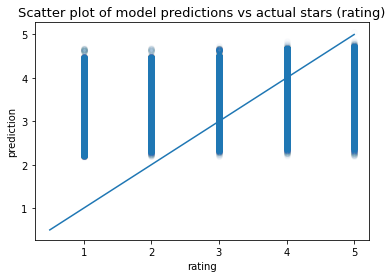

In [ ]:
plt.scatter(dfpreds.stars, dfpreds.predictions, alpha=0.01)
plt.plot([0.5,5],[0.5,5])
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title('Scatter plot of model predictions vs actual stars (rating)', fontsize=13)
plt.show()

In [ ]:
#mean and standard deviations of predictions
preds_stats=dfpreds.groupby('stars')['predictions'].describe().reset_index()
preds_stats

,stars,count,mean,std,min,25%,50%,75%,max
0,1,479793.0,2.978267,0.311463,2.167967,2.763693,2.888163,3.116322,4.683213
1,2,373086.0,3.091100,0.334349,2.198619,2.843463,3.006558,3.267820,4.697680
2,3,528177.0,3.171060,0.352843,2.197999,2.902398,3.089658,3.370645,4.734556
3,4,1104059.0,3.236998,0.368123,2.210708,2.950473,3.159070,3.456619,4.849259
4,5,1820465.0,3.280354,0.396192,2.207150,2.963788,3.190399,3.512661,5.051766


Text(0, 0.5, 'prediction')

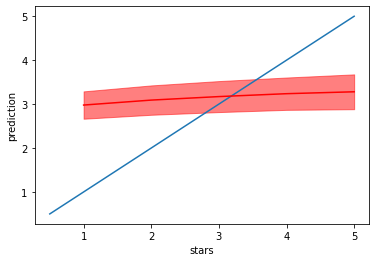

In [ ]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")

In [ ]:
ct = pd.crosstab(dfpreds.stars.astype('category'), 
                 dfpreds.predictions.apply(lambda x: round(x)).astype('category'))
ct

predictions,2,3,4,5
stars,,,,
1,3451,440152,36140,50
2,770,325590,46687,39
3,472,436262,91305,138
4,380,858570,244449,660
5,328,1350308,465743,4086


Text(0.5, 1.0, 'Confusion matrix')

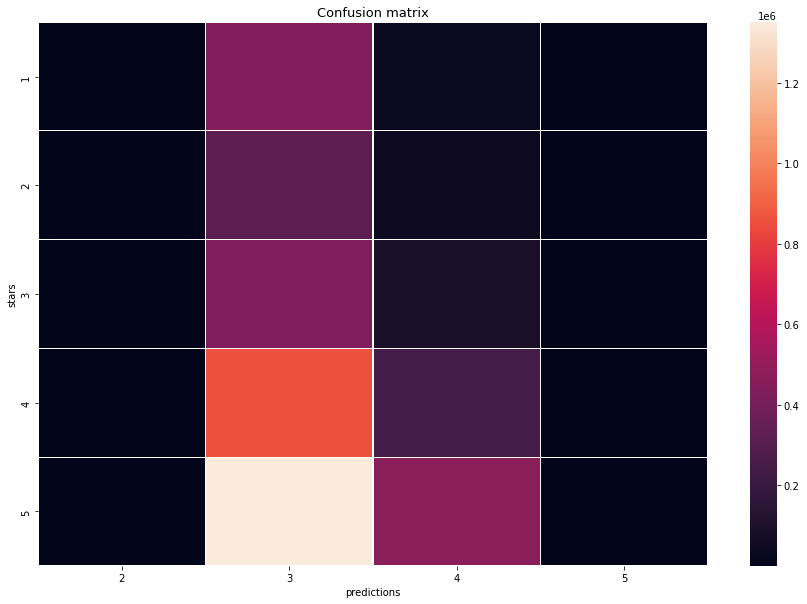

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(ct, linewidths=0.1)
plt.title('Confusion matrix', fontsize=13)

We can see that the model does well only near 3.0 stars (ratings).